# Xception Feature Extraction
### Justin Ledford

Sources: 

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

## Data and preprocessing
- Resize to 150x150
- Scale all RGB values from 0-255 to 0-1.

Using TensorFlow backend.


Found 1000 images belonging to 2 classes.


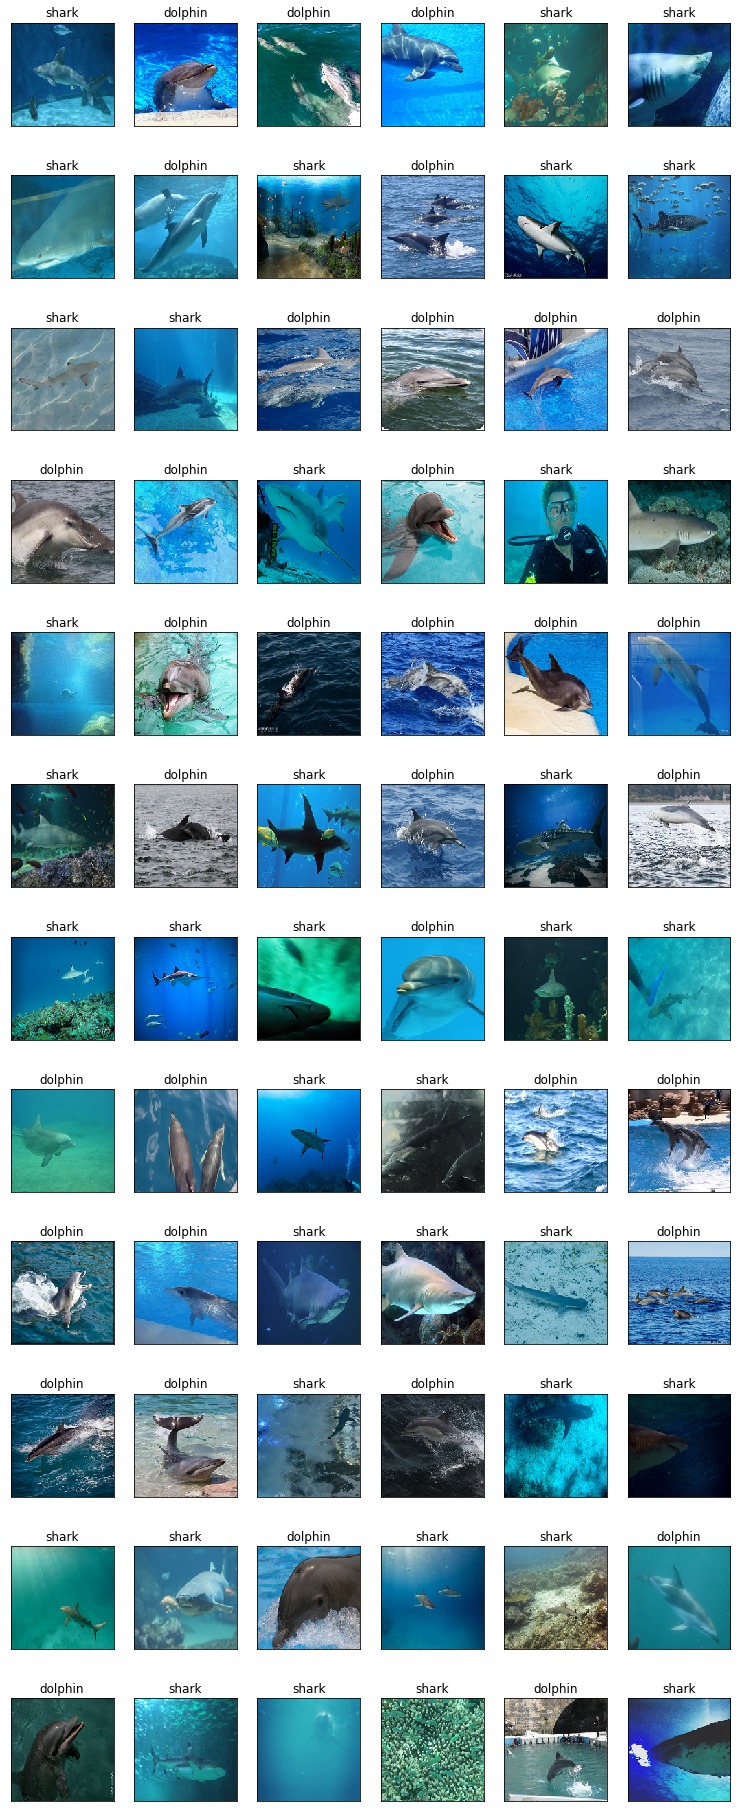

In [1]:
%matplotlib inline

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



# dimensions of our images. (must be >70 for Xception)
img_width, img_height = 150, 150

test_dir = '../data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (img_width, img_height, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
   
    if i > num_images:
        break
        
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=12, n_col=6)

# Feature Extraction
- Run all training and validation images through ResNet50 with the classifier removed
  to extract the features

In [2]:
%%time

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.applications import Xception
from keras import optimizers
import pandas as pd


top_model_weights_path = '../models/xception_bottleneck_fc_model.h5'
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


#
# Save bottleneck features from Xception
#

# build the Xception network, leaving off the top classifier layer
# so we just get the features as output
print('Building Xception...')
input_tensor = Input(shape=(img_width, img_height, 3))
base_model = Xception(weights='imagenet', include_top=False,
        input_tensor=input_tensor)

datagen = ImageDataGenerator(rescale=1/255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # class mode set to None here, because images are loaded in order, 
                     # so we know the first 1000 are dolphins, next 1000 are sharks
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('../features/xception_bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict_generator(
    generator, nb_validation_samples // batch_size)

np.save('../features/xception_bottleneck_features_validation.npy',
        bottleneck_features_validation)



Building Xception...
Found 2000 images belonging to 2 classes.
Saving bottleneck features (train)...
Found 800 images belonging to 2 classes.
Saving bottleneck features (validation)...
CPU times: user 16.5 s, sys: 4.04 s, total: 20.6 s
Wall time: 13.5 s


# Train a classifier layer with extracted features

In [3]:
%%time

epochs = 30
batch_size = 20

#
# Train top model
#

train_data = np.load('../features/xception_bottleneck_features_train.npy')
train_labels = np.array(
    [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('../features/xception_bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))


print('Building top model...')
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

print('Training top model...')
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose=1)
top_model.save_weights(top_model_weights_path)




Building top model...
Training top model...
Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 2s - loss: 1.9941 - acc: 0.8580 - val_loss: 2.1505 - val_acc: 0.8575
Epoch 2/30
2000/2000 [==============================] - 2s - loss: 1.6057 - acc: 0.8925 - val_loss: 1.2069 - val_acc: 0.9187
Epoch 3/30
2000/2000 [==============================] - 2s - loss: 1.2563 - acc: 0.9155 - val_loss: 1.0800 - val_acc: 0.9300
Epoch 4/30
2000/2000 [==============================] - 2s - loss: 0.8288 - acc: 0.9440 - val_loss: 1.0496 - val_acc: 0.9300
Epoch 5/30
2000/2000 [==============================] - 2s - loss: 0.9510 - acc: 0.9385 - val_loss: 1.0249 - val_acc: 0.9325
Epoch 6/30
2000/2000 [==============================] - 2s - loss: 0.6936 - acc: 0.9520 - val_loss: 0.9890 - val_acc: 0.9362
Epoch 7/30
2000/2000 [==============================] - 2s - loss: 0.8962 - acc: 0.9415 - val_loss: 1.0120 - val_acc: 0.9337
Epoch 8/30
2000/2000 [============

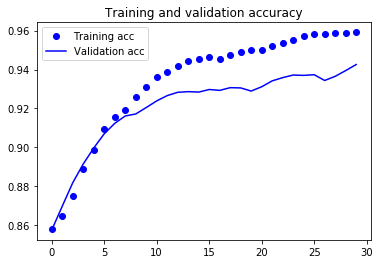

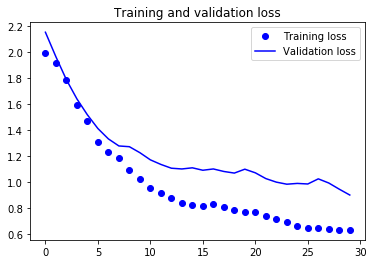

In [4]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history, smooth=True)

## Inspect Xception layers to determine block to fine tune

In [5]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 74, 74, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 74, 74, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
%%time

epochs = 100
batch_size = 16

#
# Fine tune top convulational block
#

print('Building combined model...')
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input,
              outputs=top_model(base_model.output))

# Freeze all blocks up to block5 (the block we are fine tuning)
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


# fine-tune the model
print('Training combined model...')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1)

#pd.DataFrame(history.history).to_csv('../logs/fine-tune-%s.csv' % SLURM_JOBID)

Building combined model...
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Training combined model...
Epoch 1/100
7/7 [==============================] - 3s - loss: 3.4510 - acc: 0.7679 - val_loss: 0.7728 - val_acc: 0.9500
Epoch 2/100
7/7 [==============================] - 2s - loss: 1.5235 - acc: 0.8839 - val_loss: 0.9805 - val_acc: 0.9350
Epoch 3/100
7/7 [==============================] - 2s - loss: 2.6718 - acc: 0.8214 - val_loss: 0.8650 - val_acc: 0.9463
Epoch 4/100
7/7 [==============================] - 2s - loss: 3.3136 - acc: 0.7857 - val_loss: 0.9834 - val_acc: 0.9363
Epoch 5/100
7/7 [==============================] - 2s - loss: 3.2141 - acc: 0.7857 - val_loss: 0.9423 - val_acc: 0.9400
Epoch 6/100
7/7 [==============================] - 2s - loss: 2.2676 - acc: 0.8571 - val_loss: 0.9555 - val_acc: 0.9400
Epoch 7/100
7/7 [==============================] - 2s - loss: 1.9296 - acc: 0.8750 - val_loss: 0.8342 - val_acc: 0.9437
Epoch 8/100
7/7 [======

7/7 [==============================] - 2s - loss: 2.9941 - acc: 0.8036 - val_loss: 1.8150 - val_acc: 0.8812
Epoch 68/100
7/7 [==============================] - 2s - loss: 2.1505 - acc: 0.8571 - val_loss: 1.7072 - val_acc: 0.8900
Epoch 69/100
7/7 [==============================] - 2s - loss: 1.8408 - acc: 0.8750 - val_loss: 1.6871 - val_acc: 0.8888
Epoch 70/100
7/7 [==============================] - 2s - loss: 1.8721 - acc: 0.8571 - val_loss: 1.4626 - val_acc: 0.9075
Epoch 71/100
7/7 [==============================] - 2s - loss: 1.4313 - acc: 0.9107 - val_loss: 1.2862 - val_acc: 0.9125
Epoch 72/100
7/7 [==============================] - 2s - loss: 1.6882 - acc: 0.8750 - val_loss: 1.2989 - val_acc: 0.9125
Epoch 73/100
7/7 [==============================] - 2s - loss: 1.2858 - acc: 0.9196 - val_loss: 1.1799 - val_acc: 0.9237
Epoch 74/100
7/7 [==============================] - 2s - loss: 1.4024 - acc: 0.9107 - val_loss: 1.1285 - val_acc: 0.9237
Epoch 75/100
7/7 [===========================

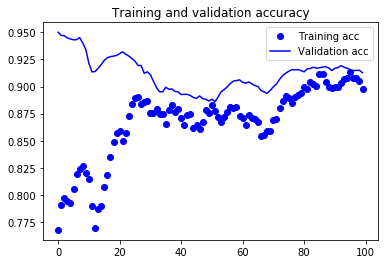

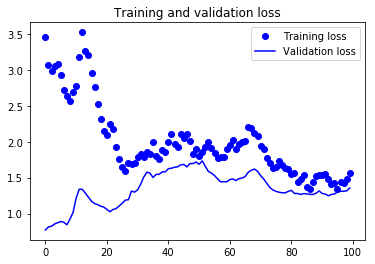

In [7]:
plot_training_validation_acc(history, smooth=True)

In [9]:
test_dir = '../data/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.921999994516


Found 1000 images belonging to 2 classes.


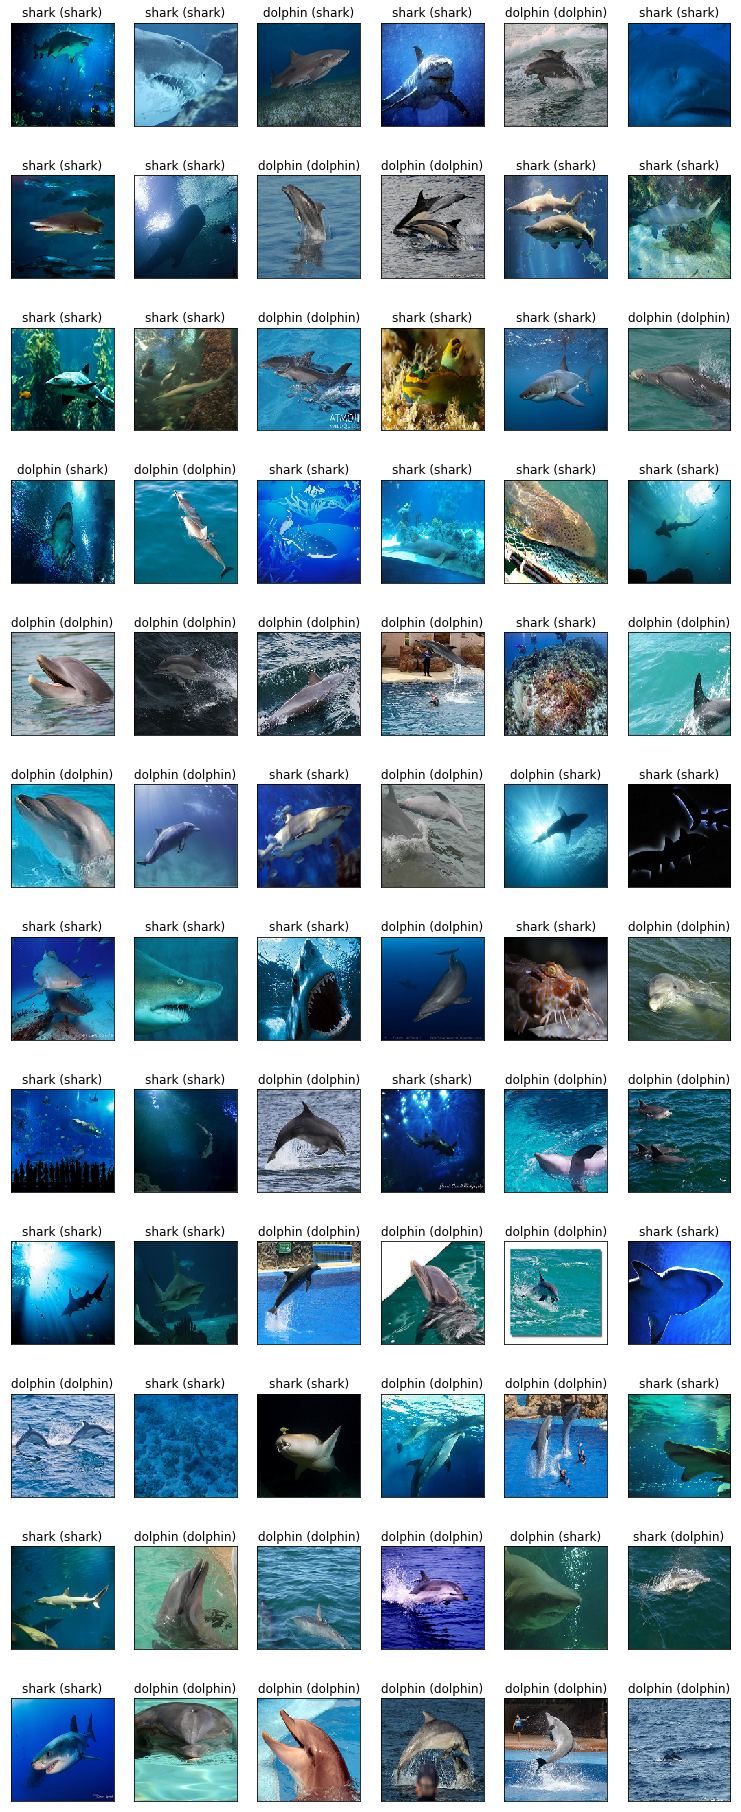

In [10]:
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
predictions = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (img_width, img_height, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] > .5 else 'dolphin')
    y_hat = model.predict(inputs)
    predictions.append('shark' if y_hat > .5 else 'dolphin')
   
    if i > num_images:
        break
        
for i in range(num_images):
    predictions[i] += ' (%s)' % titles[i]
        
plot_gallery(images, predictions, n_row=12, n_col=6)